### Factorization Machine

In this jupyter notebook, I built a Factoriztion Machine with [LightFM](https://github.com/lyst/lightfm), using data from user-traits. 

Just as most of the collective matrix factorization approch, Factorization machine captures multiple relationships between multiple entities. FM models interactions between features through using factorized parameters. They are extremely effective on sparse data. It learns embeddings (latent representations in a high-dimensional space) for users and items in a way that encodes user preferences over items. When multiplied together, these representations produce scores for every item for a given user. The latent space is then stored and build an ANN index with [all2vec](https://github.com/iheartradio/all2vec) for fast querying at scale.

There are few advanteges using FM:
+ it has clever and generic feature representation to cast factorization so that it has linear computation time with all interactions between features
+ The second order Factorization machine mimic the result as matrix factorization eg. SVD++ (get what we want but faster)
+ Produce Latent Space (user-latent vectors)
+ I set the loss as Bayesian personalized ranking from implicit feedback since we have only positive pair present in data. The loss emphasizes the positive user-trait pair by maximizing the prediction difference between positive observation and negative ones (randomly sampled). In the hope that it will help to distinguish users who have different traits and push their vectors further apart. I choose SGD for fast convergence.
(We might find a loss better fit our problem.)



Note that:
+ I did not plot the loss I did not check how to output loss for this library (whcih has better implementation than the others) will add the loss change with repsect to iteration later. 
+ Currently the model is evaluated under precision at k, need to edit this function with hamming distance and grid search
+ building and training the model & ANN is really fast. But visualization with tnse in sklearn takes too long. (I will switch to pyspark tnse implementation in google cloud)

In [2]:
from lightfm.data import Dataset
import pandas as pd
from lightfm.evaluation import precision_at_k
from lightfm import LightFM
import numpy as np
from posixpath import join
from all2vec import EntitySet
import itertools

INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials


In [3]:
file_path = 'sample.csv'
df = pd.read_csv(file_path, index_col='Unnamed: 0')
df.info(null_counts=True)

df = df.sample(10000)

/home/suils789/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:522: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1371486 entries, 278554 to 53136
Data columns (total 6 columns):
uuid                     1371486 non-null object
encodedTraits.type       1371486 non-null int64
encodedTraits.size       1371486 non-null int64
encodedTraits.indices    1371486 non-null object
encodedTraits.values     1371486 non-null object
from_file                1371486 non-null int64
dtypes: int64(3), object(3)
memory usage: 73.2+ MB


In [7]:
RANK=8
EPOCHS=25
LOSS='bpr'
USE_NUMERIC = False

In [4]:
# feed all user and items to create matrix indices
user_ids = df['uuid'].unique().tolist()
item_ids = set([ele for x in df['encodedTraits.indices'].values for ele in eval(x)])
dataset = Dataset()
dataset.fit(
	(uid for uid in user_ids),
	(iid for iid in item_ids)
	)

num_users, num_items = dataset.interactions_shape()


In [5]:
#build training/testing sparse matrix
# in format of (uid, itemid) pair
(interactions, weights) = dataset \
    .build_interactions(((row[1],item,1)for row in df.head().itertuples() for item in eval(row[4])))

In [8]:
# train - all items are positive signals
implicit_model = LightFM(no_components=RANK, loss=LOSS)
implicit_model.fit(interactions, epochs=EPOCHS)

In [9]:
print(precision_at_k(implicit_model, interactions, k=2).mean())

0.8


### II. ANN (Approximate Nearest Neighbors) Fast Look up 
k-d tree

The idea is to put users and traits encoded vectors into the same space for interpretation.

### Clustering Visualization



In [12]:
# id -> matrix index
(user_map, _, _, item_map) = dataset.mapping()

# fast NNS
t = EntitySet(8)
t.create_entity_type(1, 'user', 30)
t.create_entity_type(2, 'item', 30)


for k, i in user_map.items():
	v = implicit_model.user_embeddings[i]
	t.add_item(1, k, v / np.linalg.norm(v))

for k, i in item_map.items():
	v = implicit_model.item_embeddings[i]
	if isinstance(k, int):
		# two ids for same movie title
		try:
			t.add_item(2, k, v / np.linalg.norm(v))
		except ValueError:
			continue
	else:
		t.add_item(3, k, v / np.linalg.norm(v))

t.build()

INFO:root:Starting build for entity 1 - user...
INFO:root:Done build for entity 1 - user
INFO:root:Starting build for entity 2 - item...
INFO:root:Done build for entity 2 - item


### Visualization needs to be tuned

In [18]:
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn import manifold
tsne = manifold.TSNE(n_components=2,perplexity=50.0, init='random')
latent_space = tsne.fit_transform(implicit_model.user_embeddings)

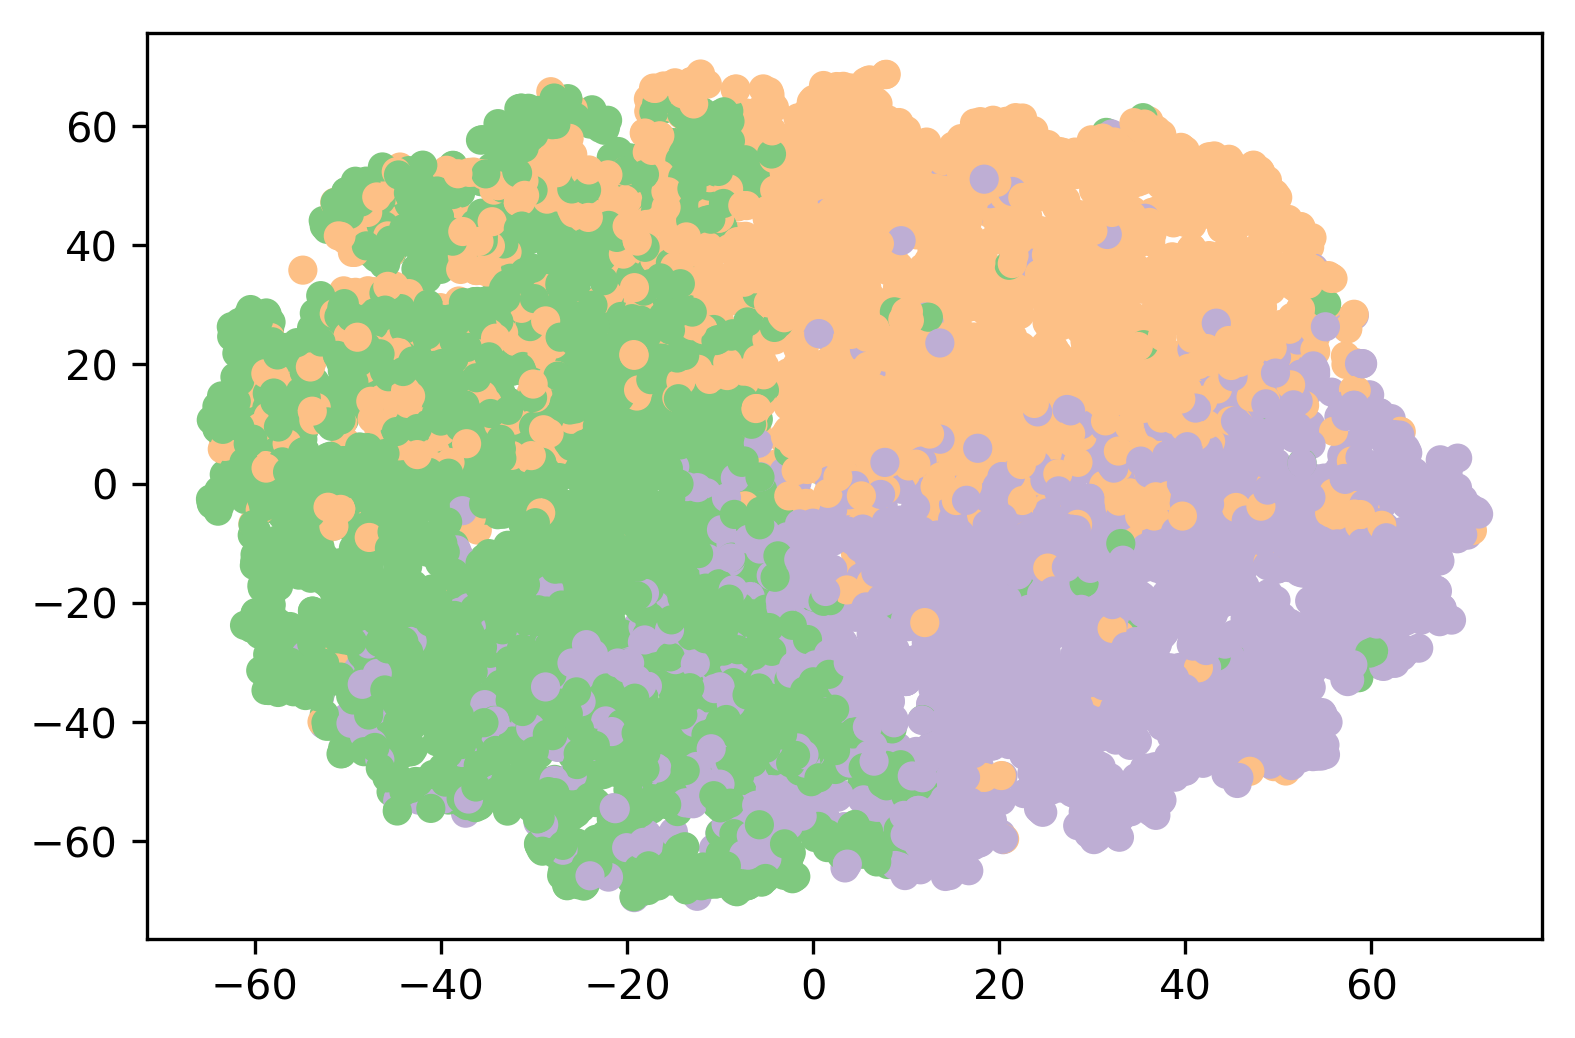

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.dpi'] = "300"
dbs = KMeans(n_clusters=3).fit(implicit_model.user_embeddings)
plt.scatter(latent_space[:,0], latent_space[:,1], c=plt.cm.Accent(dbs.labels_))